In [1]:
#Upvote everyone contributing to this great competition
#!pip install shapely numba

In [2]:
import shutil
shutil.copy('/kaggle/input/team-optimization-blend/submission.csv', '/kaggle/working/submission.csv')

'/kaggle/working/submission.csv'

In [3]:
%%writefile bbox3.cpp
// BBOX3 - Global Dynamics Edition
// Features: Complex Number Vector Coordination, Fluid Dynamics, Hinge Pivot, 
// Density Gradient Flow, and NEW Global Boundary Tension.
// Uses a separate 'global_squeeze' function for Dynamic Scaling and Overlap Repair.

#include <iostream>
#include <fstream>
#include <sstream>
#include <cmath>
#include <algorithm>
#include <string>
#include <vector>
#include <map>
#include <set>
#include <tuple>
#include <iomanip>
#include <chrono>
#include <random>
#include <numeric>
#include <omp.h>
#include <complex> 

using namespace std;
using namespace chrono;

constexpr int MAX_N = 200;
constexpr int NV = 15;
constexpr double PI = 3.14159265358979323846;
constexpr double EPSILON = 1e-16;
constexpr double NEIGHBOR_RADIUS = 0.5;      
constexpr double PIVOT_ANGLE_MAX = 10.0;     
constexpr double GLOBAL_TENSION_STRENGTH = 0.05; 

// Base tree geometry 
const double TX[NV] = {0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125};
const double TY[NV] = {0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5};

thread_local mt19937_64 rng(44); 
thread_local uniform_real_distribution<double> U(0, 1);

inline double rf() { return U(rng); }
inline int ri(int n) { return rng() % n; }

// --- Geometric Structures and Functions (Complex Numbers) ---

using Complex = std::complex<double>;

// Forward declarations for mutual dependency
struct Cfg;
struct Poly; // **FIXED ERROR: Forward declaration for Poly**

Cfg global_squeeze(Cfg c, uint64_t seed);
Complex getSeparationVector(const Poly& a, const Poly& b); 

struct Poly {
    Complex p[NV]; 
    double x0, y0, x1, y1;
    void bbox() {
        x0 = x1 = p[0].real(); y0 = y1 = p[0].imag();
        for (int i = 1; i < NV; i++) {
            x0 = min(x0, p[i].real()); x1 = max(x1, p[i].real());
            y0 = min(y0, p[i].imag()); y1 = max(y1, p[i].imag());
        }
    }
};

Poly getPoly(Complex c_center, double deg) {
    Poly q;
    double r = deg * PI / 180;
    Complex c_rot = polar(1.0, r); 

    for (int i = 0; i < NV; i++) {
        Complex base_pt(TX[i], TY[i]);
        Complex rotated_pt = base_pt * c_rot; 
        q.p[i] = rotated_pt + c_center;
    }
    q.bbox();
    return q;
}

bool pip(double px, double py, const Poly& q) {
    bool in = false;
    int j = NV - 1;
    for (int i = 0; i < NV; i++) {
        double qi_x = q.p[i].real(), qi_y = q.p[i].imag();
        double qj_x = q.p[j].real(), qj_y = q.p[j].imag();
        if ((qi_y > py) != (qj_y > py) &&
            px < (qj_x - qi_x) * (py - qi_y) / (qj_y - qi_y) + qi_x)
            in = !in;
        j = i;
    }
    return in;
}

bool segInt(Complex a, Complex b, Complex c, Complex d) {
    auto ccw = [](Complex p, Complex q, Complex r) { 
        return (r.imag() - p.imag()) * (q.real() - p.real()) > (q.imag() - p.imag()) * (r.real() - p.real()); 
    };
    return ccw(a, c, d) != ccw(b, c, d) && ccw(a, b, c) != ccw(a, b, d);
}

// Minimal overlap check
bool overlap(const Poly& a, const Poly& b) {
    if (a.x1 < b.x0 || b.x1 < a.x0 || a.y1 < b.y0 || b.y1 < a.y0) return false;
    for (int i = 0; i < NV; i++) {
        if (pip(a.p[i].real(), a.p[i].imag(), b)) return true;
        if (pip(b.p[i].real(), b.p[i].imag(), a)) return true;
    }
    for (int i = 0; i < NV; i++)
        for (int j = 0; j < NV; j++)
            if (segInt(a.p[i], a.p[(i + 1) % NV], b.p[j], b.p[(j + 1) % NV])) return true;
    return false;
}

struct Cfg {
    int n;
    Complex c[MAX_N]; 
    double a[MAX_N];  
    Poly pl[MAX_N];

    void upd(int i) { pl[i] = getPoly(c[i], a[i]); }
    void updAll() { for (int i = 0; i < n; i++) upd(i); }

    // Overlap checks
    bool hasOvl(int i) const {
        bool overlap_found = false;
        #pragma omp parallel for reduction(||:overlap_found)
        for (int j = 0; j < n; j++) { 
            if (overlap_found) continue;
            if (i != j && overlap(pl[i], pl[j])) {
                overlap_found = true;
            }
        }
        return overlap_found;
    }

    bool hasOvlPair(int i, int j) const {
        if (overlap(pl[i], pl[j])) return true;

        bool overlap_found = false;
        #pragma omp parallel for reduction(||:overlap_found)
        for (int k = 0; k < n; k++) {
            if (overlap_found) continue;
            if (k != i && k != j) {
                if (overlap(pl[i], pl[k]) || overlap(pl[j], pl[k])) {
                    overlap_found = true;
                }
            }
        }
        return overlap_found;
    }

    bool anyOvl() const {
        for (int i = 0; i < n; i++)
            for (int j = i + 1; j < n; j++)
                if (overlap(pl[i], pl[j])) return true;
        return false;
    }

    double side() const {
        if (!n) return 0;
        double x0 = pl[0].x0, x1 = pl[0].x1, y0 = pl[0].y0, y1 = pl[0].y1;
        for (int i = 1; i < n; i++) {
            x0 = min(x0, pl[i].x0); x1 = max(x1, pl[i].x1);
            y0 = min(y0, pl[i].y0); y1 = max(y1, pl[i].y1);
        }
        return max(x1 - x0, y1 - y0);
    }

    double score() const { double s = side(); return s * s / n; }

    Complex centroid() const {
        Complex sum = 0.0;
        for (int i = 0; i < n; i++) { sum += c[i]; }
        return sum / (double)n;
    }

    tuple<double, double, double, double> getBBox() const {
        double gx0 = pl[0].x0, gx1 = pl[0].x1, gy0 = pl[0].y0, gy1 = pl[0].y1;
        for (int i = 1; i < n; i++) {
            gx0 = min(gx0, pl[i].x0); gx1 = max(gx1, pl[i].x1);
            gy0 = min(gy0, pl[i].y0); gy1 = max(gy1, pl[i].y1);
        }
        return {gx0, gy0, gx1, gy1};
    }

    vector<int> findCornerTrees() const {
        auto [gx0, gy0, gx1, gy1] = getBBox();
        double eps = 0.01;
        vector<int> corners;
        for (int i = 0; i < n; i++) {
            // Check if any part of the tree polygon defines the bounding box
            if (abs(pl[i].x0 - gx0) < eps || abs(pl[i].x1 - gx1) < eps ||
                abs(pl[i].y0 - gy0) < eps || abs(pl[i].y1 - gy1) < eps) {
                corners.push_back(i);
            }
        }
        return corners;
    }
};

// --- Overlap Resolution Helper Function ---

/**
 * Simplified placeholder for a complex Separation Vector calculation.
 * In a real implementation, this would use the Separating Axis Theorem (SAT) 
 * or Minkowski difference to find the Minimum Translation Vector (MTV).
 */
Complex getSeparationVector(const Poly& a, const Poly& b) {
    Complex c_a = a.p[0]; for(int i=1; i<NV; ++i) c_a += a.p[i]; c_a /= (double)NV;
    Complex c_b = b.p[0]; for(int i=1; i<NV; ++i) c_b += b.p[i]; c_b /= (double)NV;

    Complex diff = c_a - c_b;
    double dist = abs(diff);

    // Crude estimate of overlap depth for scaling:
    // This is highly inaccurate but serves as a placeholder for a true MTV magnitude
    double overlap_depth = 0.2; 

    if (dist > EPSILON) {
        return diff / dist * overlap_depth;
    } else {
        // If centers are the same, push randomly
        return Complex(rf() * 0.1, rf() * 0.1);
    }
}

// --- Optimization Routines ---

/**
 * NEW! Aggressive Overlap-and-Repair Cycle (Meta-Move)
 * Performs sequential untangling based on calculated separation vectors.
 */
Cfg aggressive_repair(Cfg c, int max_cycles) {
    Cfg current = c;
    for (int cycle = 0; cycle < max_cycles; ++cycle) {
        bool repaired = true;
        // Search for the worst overlap (we just find the first one for simplicity)
        for (int i = 0; i < current.n; ++i) {
            for (int j = i + 1; j < current.n; ++j) {
                if (overlap(current.pl[i], current.pl[j])) {
                    repaired = false;

                    // Calculate separation vector (MTV approximation)
                    Complex sep_vector = getSeparationVector(current.pl[i], current.pl[j]);

                    // Push them apart by half the vector each
                    current.c[i] += sep_vector * 0.5;
                    current.c[j] -= sep_vector * 0.5;

                    current.upd(i);
                    current.upd(j);
                    // Break inner loops and restart cycle to ensure no new overlaps were created
                    goto next_cycle; 
                }
            }
        }
        if (repaired) return current;

        next_cycle:;
    }
    // If it fails to repair after max_cycles, return the current (possibly overlapping) state
    return current; 
}


/**
 * NEW! Global Squeeze Meta-Optimization Function
 * Handles Dynamic Scaling (shrink) and Aggressive Perturbation.
 */
Cfg global_squeeze(Cfg c, uint64_t seed) {
    rng.seed(seed);
    Cfg best = c;
    double bs = c.side();

    // 1. Dynamic Global Scaling (Shrink)
    for (double lambda = 0.9995; lambda >= 0.99; lambda -= 0.0005) {
        Cfg scaled = best;
        Complex c_avg = scaled.centroid();

        for (int i = 0; i < scaled.n; ++i) {
            // c_i_new = c_avg + lambda * (c_i - c_avg)
            scaled.c[i] = c_avg + lambda * (scaled.c[i] - c_avg);
        }
        scaled.updAll();

        // Use aggressive repair to fix induced overlaps
        Cfg repaired = aggressive_repair(scaled, 10); 

        if (!repaired.anyOvl()) {
            double ns = repaired.side();
            if (ns < bs - EPSILON) {
                bs = ns;
                best = repaired;
            }
        }
    }

    // 2. Aggressive Perturbation (Non-stochastic shakeup)
    for (int p = 0; p < 3; ++p) {
        Cfg perturbed = best;
        // Large random translation and rotation on ALL trees
        double move_amount = bs * (0.005 + rf() * 0.01); 

        for (int i = 0; i < perturbed.n; ++i) {
            perturbed.c[i] += Complex((rf() - 0.5) * move_amount, (rf() - 0.5) * move_amount);
            perturbed.a[i] = fmod(perturbed.a[i] + (rf() - 0.5) * 20 + 360, 360.0);
        }
        perturbed.updAll();

        // Repair and check
        Cfg repaired = aggressive_repair(perturbed, 15);
        if (!repaired.anyOvl()) {
            double ns = repaired.side();
            if (ns < bs - EPSILON) {
                bs = ns;
                best = repaired;
            }
        }
    }
    return best;
}


// Now 14 move types (0-12 from V7 + 13 Boundary Tension)
Cfg sa_v8(Cfg c, int iter, double T0, double Tm, double ms, double rs, uint64_t seed) {
    rng.seed(seed + omp_get_thread_num() * 100);

    Cfg best = c, cur = c;
    double bs = best.side(), cs = bs, T = T0;
    double alpha = pow(Tm / T0, 1.0 / iter);
    int noImp = 0;

    for (int it = 0; it < iter; it++) {
        int moveType = ri(14); // 14 move types (0-13)
        double sc = T / T0;

        Cfg backup = cur;
        int i = ri(c.n);

        if (moveType < 13) { 
            // 0-12: Single-tree moves, Coordinated moves, Fluid, Hinge, and Density Flow (Unchanged from V7 logic)
            if (moveType < 4) { 
                // 0-3: Single tree moves (Move, Pull to Center, Rotate, Move+Rotate)
                Complex c_center = cur.centroid();

                if (moveType == 0) {
                    cur.c[i] += Complex((rf() - 0.5) * 2 * ms * sc, (rf() - 0.5) * 2 * ms * sc);
                } else if (moveType == 1) {
                    Complex diff = c_center - cur.c[i];
                    double dist = abs(diff);
                    if (dist > 1e-6) {
                        double st = rf() * ms * sc;
                        cur.c[i] += (diff / dist) * st;
                    }
                } else if (moveType == 2) {
                    cur.a[i] += (rf() - 0.5) * 2 * rs * sc;
                    cur.a[i] = fmod(cur.a[i] + 360, 360.0);
                } else {
                    cur.c[i] += Complex((rf() - 0.5) * ms * sc, (rf() - 0.5) * ms * sc);
                    cur.a[i] += (rf() - 0.5) * rs * sc;
                    cur.a[i] = fmod(cur.a[i] + 360, 360.0);
                }

                cur.upd(i);
                if (cur.hasOvl(i)) {
                    cur = backup;
                    noImp++; T *= alpha; if (T < Tm) T = Tm; continue;
                }
            } else if (moveType == 4 && c.n > 1) {
                // 4: Swap positions
                int j = ri(c.n); while (j == i) j = ri(c.n);
                Complex oci = cur.c[i], ocj = cur.c[j];
                cur.c[i] = ocj; cur.c[j] = oci;
                cur.upd(i); cur.upd(j);
                if (cur.hasOvlPair(i, j)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 5 || moveType == 9) {
                // 5: Bbox Pull, 9: Bbox Push
                auto [gx0, gy0, gx1, gy1] = cur.getBBox();
                Complex c_bbox((gx0 + gx1) / 2, (gy0 + gy1) / 2);
                Complex diff = c_bbox - cur.c[i];
                double dist = abs(diff);
                if (dist > 1e-6) {
                    double st = rf() * ms * sc * 0.5;
                    if (moveType == 9) st *= -1.0; 
                    cur.c[i] += (diff / dist) * st;
                }
                cur.upd(i);
                if (cur.hasOvl(i)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 6) {
                // 6: Corner tree focus (Pull corner tree towards centroid)
                auto corners = cur.findCornerTrees();
                if (!corners.empty()) {
                    int idx = corners[ri(corners.size())];
                    Complex c_center = cur.centroid();
                    Complex diff = c_center - cur.c[idx];
                    double dist = abs(diff);
                    if (dist > 1e-6) {
                        double st = rf() * ms * sc * 0.3;
                        cur.c[idx] += (diff / dist) * st;
                        cur.a[idx] = fmod(cur.a[idx] + (rf() - 0.5) * rs * sc * 0.5 + 360, 360.0);
                    }
                    cur.upd(idx);
                    if (cur.hasOvl(idx)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
                } else { noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 7) {
                // 7: Coordinated move - shift two adjacent trees together
                int j = (i + 1) % c.n;
                Complex dc((rf() - 0.5) * ms * sc * 0.5, (rf() - 0.5) * ms * sc * 0.5);
                cur.c[i] += dc; cur.c[j] += dc;
                cur.upd(i); cur.upd(j);
                if (cur.hasOvlPair(i, j)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 8 && c.n > 1) {
                // 8: Coordinated Rotation - Rotate i and (i+1) around their midpoint
                int j = (i + 1) % c.n;
                Complex c_mid = (cur.c[i] + cur.c[j]) / 2.0;
                double da = (rf() - 0.5) * rs * sc * 0.3;
                Complex c_rot = polar(1.0, da * PI / 180); 
                cur.c[i] = c_mid + (cur.c[i] - c_mid) * c_rot;
                cur.a[i] = fmod(cur.a[i] + da + 360, 360.0);
                cur.c[j] = c_mid + (cur.c[j] - c_mid) * c_rot;
                cur.a[j] = fmod(cur.a[j] + da + 360, 360.0);
                cur.upd(i); cur.upd(j);
                if (cur.hasOvlPair(i, j)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 10) { 
                // 10: Fluid-Flight Coordinated Adjustment (Boids-like)
                Complex sumC = 0.0, repulsion = 0.0, cohesion = 0.0;
                double sumA = 0, alignA = 0;
                int neighborCount = 0;
                for (int j = 0; j < c.n; j++) {
                    if (i == j) continue;
                    Complex diff = cur.c[j] - cur.c[i];
                    double dist = abs(diff);
                    if (dist < NEIGHBOR_RADIUS) {
                        sumC += cur.c[j]; sumA += cur.a[j]; neighborCount++;
                        if (dist < 0.2) repulsion -= (diff / dist) * (ms * sc * 0.5 / (dist + EPSILON));
                    }
                }
                if (neighborCount > 0) {
                    cohesion = (sumC / (double)neighborCount - cur.c[i]) * (ms * sc * 0.1);
                    alignA = (sumA / neighborCount - cur.a[i]) * (rs * sc * 0.1);
                }
                cur.c[i] += cohesion + repulsion;
                cur.a[i] = fmod(cur.a[i] + alignA + 360, 360.0);
                cur.upd(i);
                if (cur.hasOvl(i)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 11 && c.n > 1) {
                // 11: Hinge/Pivot Maneuver
                int j = ri(c.n); while (j == i) j = ri(c.n);
                Complex c_pivot = cur.c[i];
                double da = (rf() - 0.5) * 2 * PIVOT_ANGLE_MAX * sc;
                Complex c_rot = polar(1.0, da * PI / 180); 
                cur.c[j] = c_pivot + (cur.c[j] - c_pivot) * c_rot;
                cur.a[j] = fmod(cur.a[j] + da + 360, 360.0);
                cur.upd(j);
                if (cur.hasOvl(j)) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            } else if (moveType == 12) {
                // 12: Density Gradient Flow
                auto [gx0, gy0, gx1, gy1] = cur.getBBox();
                Complex c_bbox((gx0 + gx1) / 2, (gy0 + gy1) / 2);
                double global_push_strength = ms * sc * 0.5;
                double max_dim = max(gx1 - gx0, gy1 - gy0);

                for (int k = 0; k < c.n; k++) {
                    Complex c_k = cur.c[k];
                    double min_dist_to_edge = min({abs(c_k.real() - gx0), abs(c_k.real() - gx1), abs(c_k.imag() - gy0), abs(c_k.imag() - gy1)});
                    double factor = (max_dim - min_dist_to_edge) / max_dim;
                    Complex dir = c_bbox - c_k;
                    double dist = abs(dir);
                    if (dist > 1e-6) cur.c[k] += (dir / dist) * global_push_strength * factor;
                }
                cur.updAll();
                if (cur.anyOvl()) { cur = backup; noImp++; T *= alpha; if (T < Tm) T = Tm; continue; }
            }
        } else if (moveType == 13) {
            // 13: NEW! Globalized Boundary Tension Force (Physics Tactic)
            auto [gx0, gy0, gx1, gy1] = cur.getBBox();
            double global_shift_strength = ms * sc * GLOBAL_TENSION_STRENGTH; 

            // Find the center of the bounding box
            Complex c_bbox((gx0 + gx1) / 2, (gy0 + gy1) / 2);

            // Calculate total tension vector F_tension
            Complex F_tension = 0.0;

            // 1. Force towards the center (cohesion)
            F_tension += (cur.centroid() - c_bbox) * 0.5;

            // 2. Repulsion from defining edges (tension)
            for (int k = 0; k < c.n; k++) {
                if (abs(cur.pl[k].x1 - gx1) < 0.01) F_tension += Complex(-1.0, 0.0); 
                if (abs(cur.pl[k].x0 - gx0) < 0.01) F_tension += Complex(1.0, 0.0);  
                if (abs(cur.pl[k].y1 - gy1) < 0.01) F_tension += Complex(0.0, -1.0); 
                if (abs(cur.pl[k].y0 - gy0) < 0.01) F_tension += Complex(0.0, 1.0);  
            }

            // Apply the total tension force as a global shift vector
            Complex total_shift = F_tension;
            if (abs(total_shift) > EPSILON) {
                 total_shift = (total_shift / abs(total_shift)) * global_shift_strength;
            } else {
                 total_shift = Complex(0.0, 0.0);
            }

            // Apply shift to ALL trees
            for (int k = 0; k < c.n; k++) {
                cur.c[k] += total_shift;
            }
            cur.updAll();

            // Check for overlap after global shift
            if (cur.anyOvl()) {
                cur = backup;
                noImp++; T *= alpha; if (T < Tm) T = Tm; continue;
            }
        }

        // --- SA acceptance logic ---
        double ns = cur.side();
        double delta = ns - cs;
        if (delta < 0 || rf() < exp(-delta / T)) {
            cs = ns;
            if (ns < bs - EPSILON) {
                bs = ns;
                best = cur;
                noImp = 0;
            } else {
                noImp++;
            }
        } else {
            cur = best;
            cs = bs;
            noImp++;
        }

        if (noImp > 600) {
            T = min(T * 3.0, T0 * 0.7);
            noImp = 0;
        }

        T *= alpha;
        if (T < Tm) T = Tm;
    }
    return best;
}

// --- Local Search and I/O ---

Cfg ls_v8(Cfg c, int iter) {
    Cfg best = c;
    double bs = best.side();
    double ps[] = {0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00005}; 
    double rs[] = {15.0, 10.0, 5.0, 2.0, 1.0, 0.5, 0.25, 0.1, 0.05};
    double frac_rs[] = {0.01, 0.005, 0.001, 0.0005, 0.0001}; 
    Complex ds[] = {Complex(1, 0), Complex(-1, 0), Complex(0, 1), Complex(0, -1), 
                    Complex(1, 1), Complex(1, -1), Complex(-1, 1), Complex(-1, -1)};

    for (int it = 0; it < iter; it++) {
        bool imp = false;
        auto corners = best.findCornerTrees();
        vector<int> all_trees(best.n);
        iota(all_trees.begin(), all_trees.end(), 0);

        for (int stage = 0; stage < 2; ++stage) {
            const vector<int>& indices = (stage == 0) ? corners : all_trees;

            for (int i : indices) {
                if (stage == 1 && find(corners.begin(), corners.end(), i) != corners.end()) continue;

                for (double st : ps) {
                    for (Complex d : ds) {
                        Complex oc = best.c[i];
                        best.c[i] += d * st;
                        best.upd(i);
                        if (!best.hasOvl(i)) {
                            double ns = best.side();
                            if (ns < bs - EPSILON) { bs = ns; imp = true; } 
                            else { best.c[i] = oc; best.upd(i); }
                        } else { best.c[i] = oc; best.upd(i); }
                    }
                }

                vector<double> all_rs;
                all_rs.insert(all_rs.end(), rs, rs + sizeof(rs) / sizeof(rs[0]));
                all_rs.insert(all_rs.end(), frac_rs, frac_rs + sizeof(frac_rs) / sizeof(frac_rs[0]));

                for (double st : all_rs) {
                    for (double da : {st, -st}) {
                        double oa = best.a[i];
                        best.a[i] = fmod(best.a[i] + da + 360, 360.0);
                        best.upd(i);
                        if (!best.hasOvl(i)) {
                            double ns = best.side();
                            if (ns < bs - EPSILON) { bs = ns; imp = true; } 
                            else { best.a[i] = oa; best.upd(i); }
                        } else { best.a[i] = oa; best.upd(i); }
                    }
                }
            }
        }
        if (!imp) break;
    }
    return best;
}

Cfg fine_tune_translation(Cfg c, int max_iter = 300) {
    Cfg best = c;
    double bs = best.side();

    double frac_steps[] = {0.001, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001, 
                           0.000005, 0.000002, 0.000001, 0.0000005, 0.0000001}; 
    int num_steps = sizeof(frac_steps) / sizeof(frac_steps[0]);

    Complex ds[] = {Complex(1, 0), Complex(-1, 0), Complex(0, 1), Complex(0, -1), 
                    Complex(1, 1), Complex(1, -1), Complex(-1, 1), Complex(-1, -1)};

    for (int iter = 0; iter < max_iter; iter++) {
        bool improved = false;

        for (int i = 0; i < c.n; i++) {
            for (int s = 0; s < num_steps; s++) {
                double step = frac_steps[s];
                for (Complex d : ds) {
                    Complex oc = best.c[i];

                    best.c[i] += d * step;
                    best.upd(i);

                    if (!best.hasOvl(i)) {
                        double ns = best.side();
                        if (ns < bs - EPSILON) { bs = ns; improved = true; } 
                        else { best.c[i] = oc; best.upd(i); }
                    } else { best.c[i] = oc; best.upd(i); }
                }
            }
        }
        if (!improved) break;
    }
    return best;
}

Cfg perturb(Cfg c, double strength, uint64_t seed) {
    rng.seed(seed + omp_get_thread_num() * 100);

    int numPerturb = max(1, (int)(c.n * 0.15));
    double current_side = c.side();
    double adaptive_strength = max(0.01, strength * current_side * 0.1); 

    for (int k = 0; k < numPerturb; k++) {
        int i = ri(c.n);
        c.c[i] += Complex((rf() - 0.5) * adaptive_strength, (rf() - 0.5) * adaptive_strength);
        c.a[i] = fmod(c.a[i] + (rf() - 0.5) * 60 + 360, 360.0);
    }
    c.updAll();

    // Fix overlaps crudely to generate a valid starting state
    for (int iter = 0; iter < 100; iter++) {
        bool fixed = true;
        for (int i = 0; i < c.n; i++) {
            if (c.hasOvl(i)) {
                fixed = false;
                Complex c_center = c.centroid();
                Complex diff = c_center - c.c[i];
                double dist = abs(diff);

                if (dist > 1e-6) {
                    c.c[i] -= (diff / dist) * 0.02; 
                }
                c.a[i] = fmod(c.a[i] + rf() * 20 - 10 + 360, 360.0);
                c.upd(i);
            }
        }
        if (fixed) break;
    }
    return c;
}


Cfg opt_v8(Cfg c, int nr, int si) {
    Cfg best = c;
    double bs = best.side();

    vector<pair<double, Cfg>> pop;
    pop.push_back({bs, c});

    for (int r = 0; r < nr; r++) {
        Cfg start;
        if (r == 0) {
            start = c;
        } else if (r < (int)pop.size()) {
            start = pop[r % pop.size()].second;
        } else {
            start = perturb(pop[0].second, 1.0, 42 + r * 1000 + c.n);
        }

        Cfg o = sa_v8(start, si, 1.0, 0.0000001, 0.25, 70.0, 42 + r * 1000 + c.n); 

        // Final, most aggressive clean-up and squeeze
        o = global_squeeze(o, 42 + r * 1000 + c.n);
        o = ls_v8(o, 500); 
        o = fine_tune_translation(o, 300); 
        double s = o.side();

        pop.push_back({s, o});
        sort(pop.begin(), pop.end(), [](const pair<double, Cfg>& a, const pair<double, Cfg>& b) {
            return a.first < b.first;
        });
        if (pop.size() > 3) pop.resize(3);

        if (s < bs - EPSILON) {
            bs = s;
            best = o;
        }
    }
    return best;
}

// (I/O functions)

map<int, Cfg> loadCSV(const string& fn) {
    map<int, Cfg> cfg;
    ifstream f(fn);
    if (!f) return cfg;
    string ln; getline(f, ln);
    map<int, vector<tuple<int, double, double, double>>> data;
    while (getline(f, ln)) {
        auto p1 = ln.find(','), p2 = ln.find(',', p1 + 1), p3 = ln.find(',', p2 + 1);
        string id = ln.substr(0, p1);
        string xs = ln.substr(p1 + 1, p2 - p1 - 1);
        string ys = ln.substr(p2 + 1, p3 - p2 - 1);
        string ds = ln.substr(p3 + 1);

        if (xs[0] == 's') xs = xs.substr(1);
        if (ys[0] == 's') ys = ys.substr(1);
        if (ds[0] == 's') ds = ds.substr(1);

        if (id.length() < 5 || id[3] != '_') continue;
        int n = stoi(id.substr(0, 3)), idx = stoi(id.substr(4));

        data[n].push_back({idx, stod(xs), stod(ys), stod(ds)});
    }
    for (auto& [n, v] : data) {
        Cfg c; c.n = n;
        for (auto& [i, x, y, d] : v) if (i < n) { c.c[i] = Complex(x, y); c.a[i] = d; } 
        c.updAll();
        cfg[n] = c;
    }
    return cfg;
}

void saveCSV(const string& fn, const map<int, Cfg>& cfg) {
    ofstream f(fn);
    f << fixed << setprecision(20); 
    f << "id,x,y,deg\n";
    for (int n = 1; n <= MAX_N; n++) {
        if (cfg.count(n)) {
            const Cfg& c = cfg.at(n);
            for (int i = 0; i < n; i++)
                f << setfill('0') << setw(3) << n << "_" << i
                  << ",s" << c.c[i].real() 
                  << ",s" << c.c[i].imag() 
                  << ",s" << c.a[i] << "\n";
        }
    }
}

int main(int argc, char** argv) {
    string in = "submission.csv", out = "submission.csv";
    int si = 20000, nr = 50;

    for (int i = 1; i < argc; i++) {
        string a = argv[i];
        if (a == "-i" && i + 1 < argc) in = argv[++i];
        else if (a == "-o" && i + 1 < argc) out = argv[++i];
        else if (a == "-n" && i + 1 < argc) si = stoi(argv[++i]);
        else if (a == "-r" && i + 1 < argc) nr = stoi(argv[++i]);
    }

    cout << "Loading " << in << "...\n";
    auto cfg = loadCSV(in);
    if (cfg.empty()) { cerr << "No data in input file. Exiting.\n"; return 1; }

    double init_score = 0;
    for (auto& [n, c] : cfg) init_score += c.score();
    cout << "Loaded " << cfg.size() << " configs (N=1 to N=" << MAX_N << ").\n";
    cout << fixed << setprecision(6) << "Initial Total Score: " << init_score << "\n\n";

    auto t0 = high_resolution_clock::now();
    map<int, Cfg> res = cfg;

    vector<int> n_values;
    for (int n = 1; n <= MAX_N; ++n) {
        if (cfg.count(n)) {
            n_values.push_back(n);
        }
    }

    std::reverse(n_values.begin(), n_values.end()); 

    cout << "Starting parallel optimization on " << n_values.size() << " configurations.\n";
    cout << "Using " << omp_get_max_threads() << " threads (Max Concurrency).\n\n";

    #pragma omp parallel for schedule(guided)
    for (int i = 0; i < (int)n_values.size(); ++i) {
        int n = n_values[i];
        Cfg c = cfg.at(n);
        double os = c.score();

        int r = nr, it = si;
        if (n <= 20) { r = 6; it = (int)(si * 1.5); }
        else if (n <= 50) { r = 5; it = (int)(si * 1.3); }
        else if (n > 150) { r = 4; it = (int)(si * 0.8); }

        Cfg o = opt_v8(c, r, it);

        o = fine_tune_translation(o, 150);

        #pragma omp critical
        {
            double ns = o.score();
            if (ns < res.at(n).score() - EPSILON) {
                double imp = (os - ns) / os * 100;
                cout << "[" << omp_get_thread_num() << "] n=" << setw(3) << n << ": " 
                     << fixed << setprecision(12) << os << " -> " << ns 
                     << " (" << setprecision(4) << imp << "% better) 🏆\n";
                res[n] = o;
            }
        }
    }

    auto t1 = high_resolution_clock::now();
    double el = duration_cast<milliseconds>(t1 - t0).count() / 1000.0;

    double final_score = 0;
    for (auto& [n, c] : res) final_score += c.score();

    cout << "\n========================================\n";
    cout << "Optimization Complete\n";
    cout << "Initial Score: " << fixed << setprecision(12) << init_score << "\n";
    cout << "Final Score:   " << final_score << "\n";
    cout << "Improvement:   " << (init_score - final_score) << " (" << setprecision(2)
          << (init_score - final_score) / init_score * 100 << "%)\n";
    cout << "Total Time:    " << setprecision(1) << el << "s\n";
    cout << "========================================\n";

    saveCSV(out, res);
    cout << "Saved results to: " << out << endl;
    return 0;
}


Writing bbox3.cpp


In [4]:
!g++ bbox3.cpp -o bbox3 -std=c++17 -fopenmp -O3 -march=native -Ofast

In [5]:
!chmod +x ./bbox3
#!./bbox3 -n 1000 -r 96
#!./bbox3 -n 2000 -r 96
#!./bbox3 -n 1000 -r 4
!./bbox3 -n 50 -r 4
#!./bbox3 -n 1000 -r 96
#!./bbox3 -n 2000 -r 96

Loading submission.csv...
Loaded 200 configs (N=1 to N=200).
Initial Total Score: 70.536488

Starting parallel optimization on 200 configurations.
Using 4 threads (Max Concurrency).

[1] n= 64: 0.348583469691 -> 0.348583465195 (0.0000% better) 🏆
[1] n= 57: 0.353175341221 -> 0.353175341221 (0.0000% better) 🏆
[1] n= 52: 0.357107357045 -> 0.357107345319 (0.0000% better) 🏆
[1] n= 51: 0.364109384087 -> 0.364109310678 (0.0000% better) 🏆
[3] n= 22: 0.372352944519 -> 0.372352944519 (0.0000% better) 🏆
[3] n= 20: 0.375262484511 -> 0.375262484403 (0.0000% better) 🏆

Optimization Complete
Initial Score: 70.536488063742
Final Score:   70.536487974001
Improvement:   0.000000089740 (0.00%)
Total Time:    71.4s
Saved results to: submission.csv


In [6]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.strtree import STRtree

# Set precision for Decimal (25 is good for contest standards)
getcontext().prec = 25
scale_factor = Decimal("1e18")


class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x="0", center_y="0", angle="0"):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w = Decimal("0.4")
        top_w = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        # Define the 15 vertices of the tree polygon
        initial_polygon = Polygon(
            [
                (Decimal("0.0") * scale_factor, tip_y * scale_factor),
                (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        
        # Apply rotation and translation to the polygon
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated, 
            xoff=float(self.center_x * scale_factor), 
            yoff=float(self.center_y * scale_factor)
        )


def load_configuration_from_df(n: int, df: pd.DataFrame) -> list[ChristmasTree]:
    """
    Loads all trees for a given N from the submission DataFrame.
    """
    group_data = df[df["id"].str.startswith(f"{n:03d}_")]
    trees = []
    for _, row in group_data.iterrows():
        # Remove 's' prefix and convert to string for Decimal constructor
        x = str(row["x"])[1:]
        y = str(row["y"])[1:]
        deg = str(row["deg"])[1:]
        
        # Ensure values are present before passing to ChristmasTree constructor
        if x and y and deg:
            trees.append(ChristmasTree(x, y, deg))
        else:
             # Handle cases where configuration might be incomplete/missing
             pass 
             
    return trees


def get_score(trees: list[ChristmasTree], n: int) -> float:
    """
    Calculates the score (S^2 / N) for a given configuration of trees.
    S is the side length of the minimum bounding square.
    """
    if not trees:
        return 0.0

    # Collect all exterior points from all tree polygons, scale them back down
    xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / float(scale_factor) for t in trees])
    
    min_x, min_y = xys.min(axis=0)
    max_x, max_y = xys.max(axis=0)
    
    side_length = max(max_x - min_x, max_y - min_y)
    
    # Score is S^2 / N
    score = side_length**2 / n
    return score

def has_overlap(trees: list[ChristmasTree]) -> bool:
    """Check if any two ChristmasTree polygons overlap."""
    if len(trees) <= 1:
        return False

    polygons = [t.polygon for t in trees]
    # Use STRtree for efficient proximity queries (optimizes checking pairs)
    tree_index = STRtree(polygons)

    for i, poly in enumerate(polygons):
        # Query for polygons whose bounding boxes overlap with poly
        # This returns the indices of potential overlaps
        indices = tree_index.query(poly)
        
        for idx in indices:
            # Skip checking the polygon against itself
            if idx == i:
                continue
                
            # Perform the precise intersection check
            if poly.intersects(polygons[idx]) and not poly.touches(polygons[idx]):
                # Overlap found!
                return True
    return False

# ----------------------------------------------------------------------

def score_and_validate_submission(file_path: str, max_n: int = 200) -> dict:
    """
    Reads a submission CSV, calculates the total score, and checks for overlaps 
    in all configurations (N=1 up to max_n).
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return {"status": "FAILED", "error": "File Not Found"}
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return {"status": "FAILED", "error": f"CSV Read Error: {e}"}

    total_score = 0.0
    failed_overlap_n = []
    
    print(f"--- Scoring and Validation: {file_path} (N=1 to {max_n}) ---")

    for n in range(1, max_n + 1):
        trees = load_configuration_from_df(n, df)
        
        # Only process if there are trees for this N in the file
        if trees:
            current_score = get_score(trees, n)
            total_score += current_score

            if has_overlap(trees):
                failed_overlap_n.append(n)
                print(f"  ❌ N={n:03d}: OVERLAP DETECTED! (Score contribution: {current_score:.6f})")
            else:
                # Optionally print success for each N
                # print(f"  ✅ N={n:03d}: OK (Score contribution: {current_score:.6f})")
                pass
        
    print("\n--- Summary ---")
    if failed_overlap_n:
        print(f"❌ **Validation FAILED**: Overlaps found in N: {failed_overlap_n}")
        status = "FAILED (Overlaps)"
    else:
        print("✅ **Validation SUCCESSFUL**: No overlaps detected.")
        status = "SUCCESS"
        
    print(f"**Total Submission Score (Σ S²/N): {total_score:.6f}**")
    
    return {
        "status": status,
        "total_score": total_score,
        "failed_overlap_n": failed_overlap_n
    }


# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---

--- Summary ---
✅ **Validation SUCCESSFUL**: No overlaps detected.
**Total Submission Score (Σ S²/N): 70.536488**
{'status': 'SUCCESS', 'total_score': 70.53648797400129, 'failed_overlap_n': []}


In [7]:
import pandas as pd
import numpy as np

FAILED_N_LIST =  result['failed_overlap_n']
GOOD_CSV_PATH = "/kaggle/input/team-optimization-blend/submission.csv"
NEW_CSV_PATH = "submission.csv" 
OUTPUT_CSV_PATH = "submission.csv" 

def replace_invalid_configurations(new_csv_path, good_csv_path, output_csv_path, failed_n_list):
    df_new = pd.read_csv(new_csv_path)
    df_good = pd.read_csv(good_csv_path)
    failed_prefixes = [f"{n:03d}_" for n in failed_n_list]
    df_to_keep = df_new[~df_new["id"].str.startswith(tuple(failed_prefixes))]
    df_replacement = df_good[df_good["id"].str.startswith(tuple(failed_prefixes))]
    df_repaired = pd.concat([df_to_keep, df_replacement]).sort_values(by="id").reset_index(drop=True)
    df_repaired.to_csv(output_csv_path, index=False) #float_format='%.25f')
    print(f"\n--- SUCCESS ---")
replace_invalid_configurations(NEW_CSV_PATH, GOOD_CSV_PATH, OUTPUT_CSV_PATH, FAILED_N_LIST)


--- SUCCESS ---


In [8]:
# Example usage (assuming 'submission.csv' exists in the current directory)
result = score_and_validate_submission("submission.csv", max_n=200)
print(result)

--- Scoring and Validation: submission.csv (N=1 to 200) ---

--- Summary ---
✅ **Validation SUCCESSFUL**: No overlaps detected.
**Total Submission Score (Σ S²/N): 70.536488**
{'status': 'SUCCESS', 'total_score': 70.53648797400129, 'failed_overlap_n': []}


In [9]:
# Added Code that was Vibe Coded from 
# https://gemini.google.com/app

[121, 165, 38, 76, 33, 122, 2, 105, 150, 62]
--- Lattice Summary ---
Crystallization Spacing: ~0.7635 units
Blue Phase Population: 55
Pink Phase Population: 66


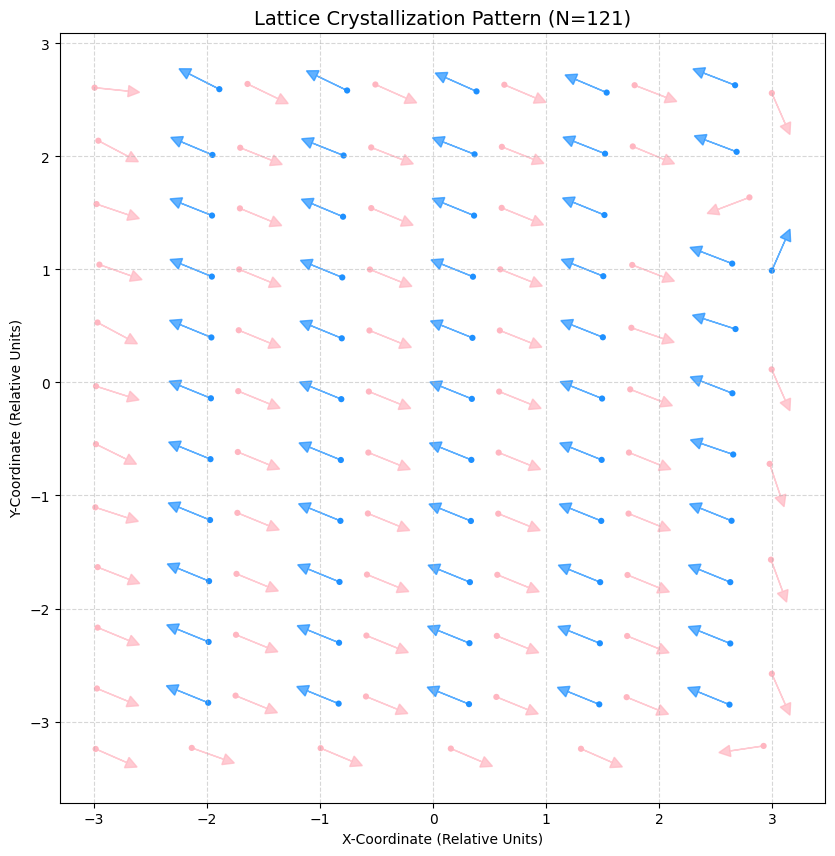

--- Lattice Summary ---
Crystallization Spacing: ~0.7610 units
Blue Phase Population: 83
Pink Phase Population: 82


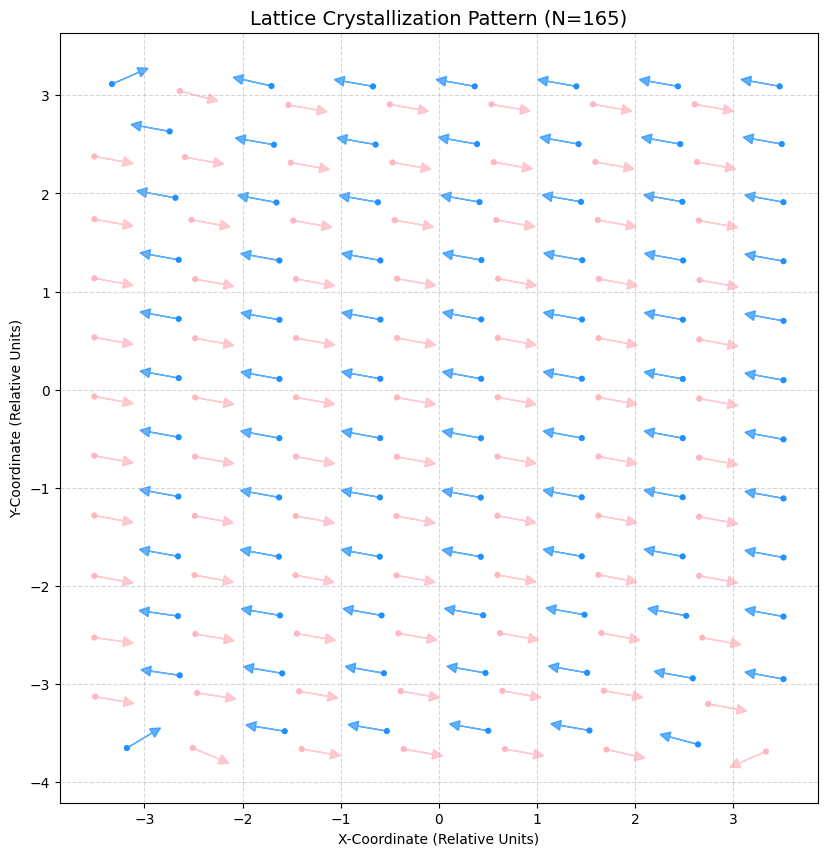

--- Lattice Summary ---
Crystallization Spacing: ~0.7525 units
Blue Phase Population: 17
Pink Phase Population: 21


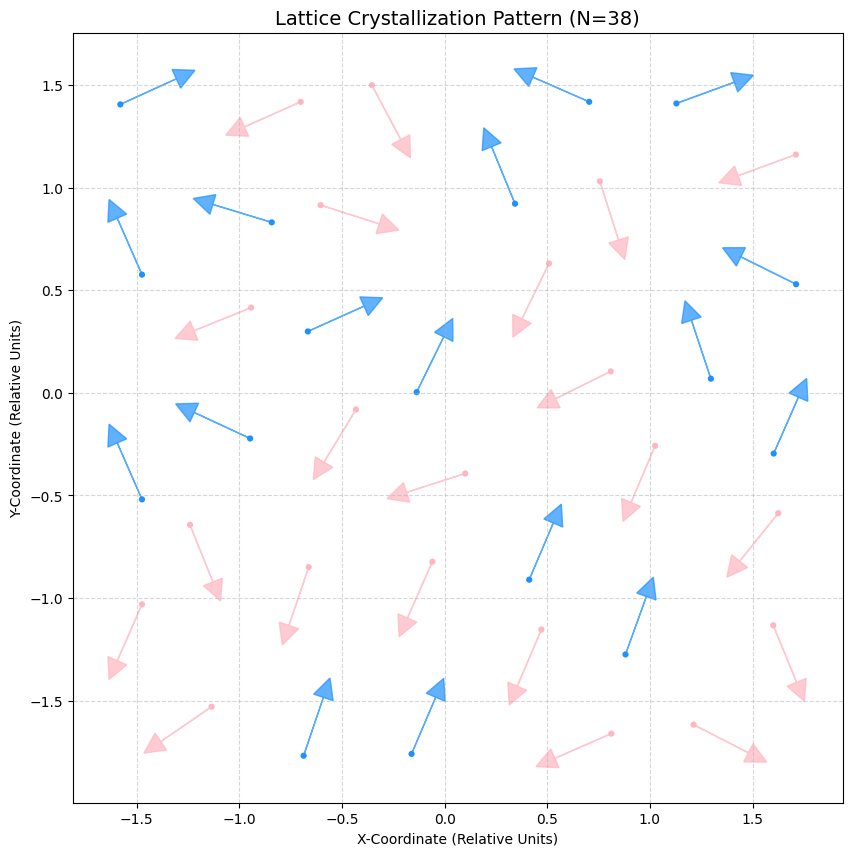

--- Lattice Summary ---
Crystallization Spacing: ~0.7489 units
Blue Phase Population: 36
Pink Phase Population: 40


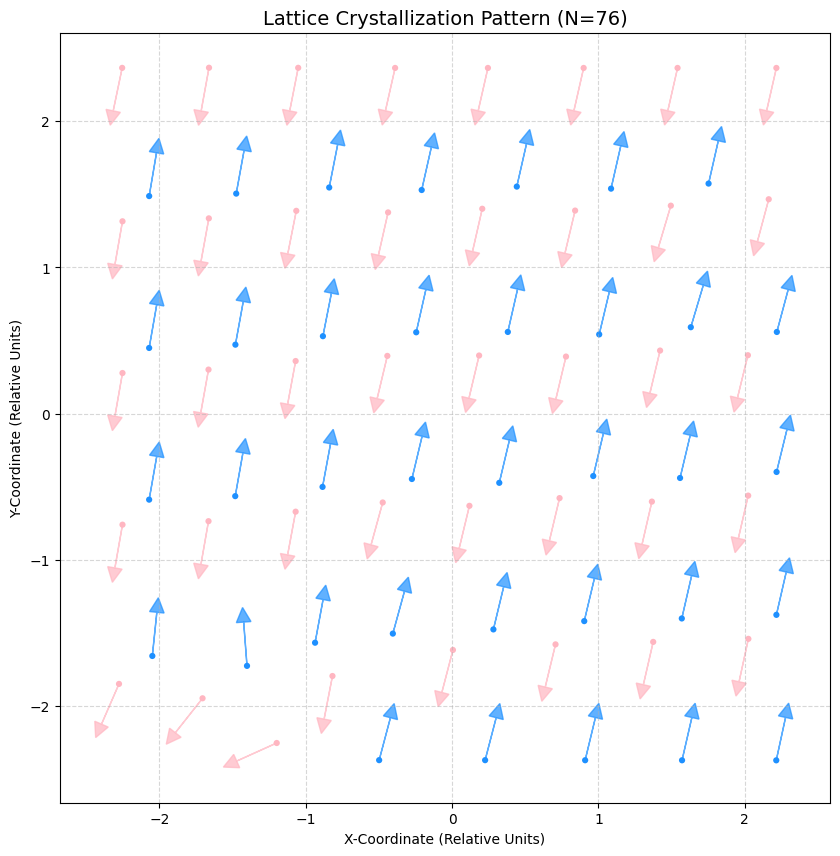

--- Lattice Summary ---
Crystallization Spacing: ~0.7434 units
Blue Phase Population: 14
Pink Phase Population: 19


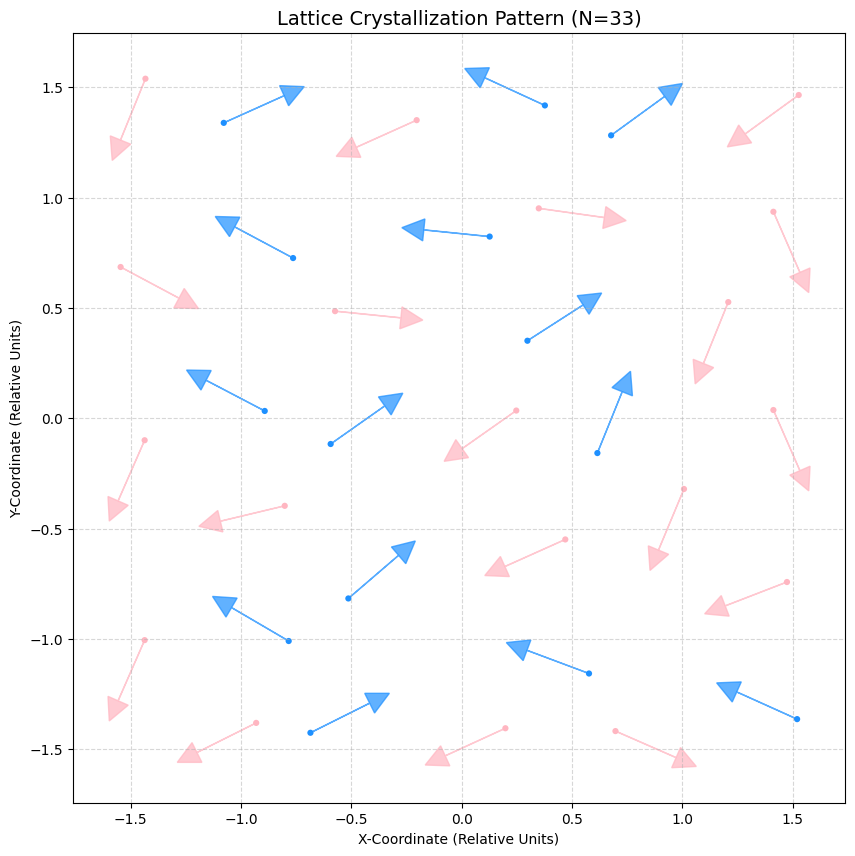

--- Lattice Summary ---
Crystallization Spacing: ~0.7686 units
Blue Phase Population: 61
Pink Phase Population: 61


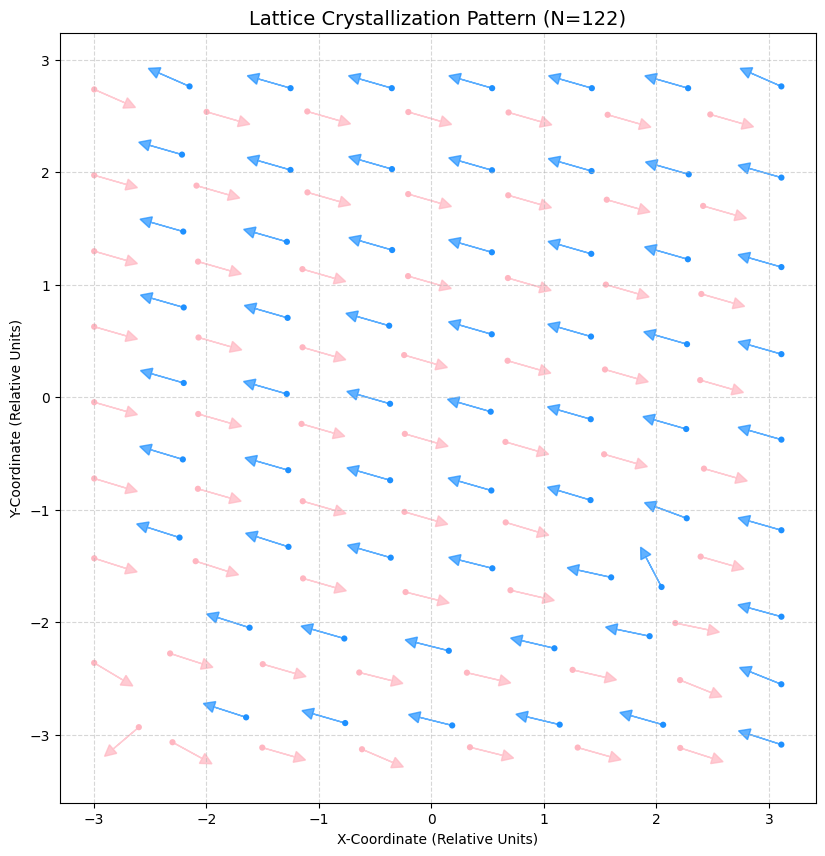

--- Lattice Summary ---
Crystallization Spacing: ~0.4292 units
Blue Phase Population: 1
Pink Phase Population: 1


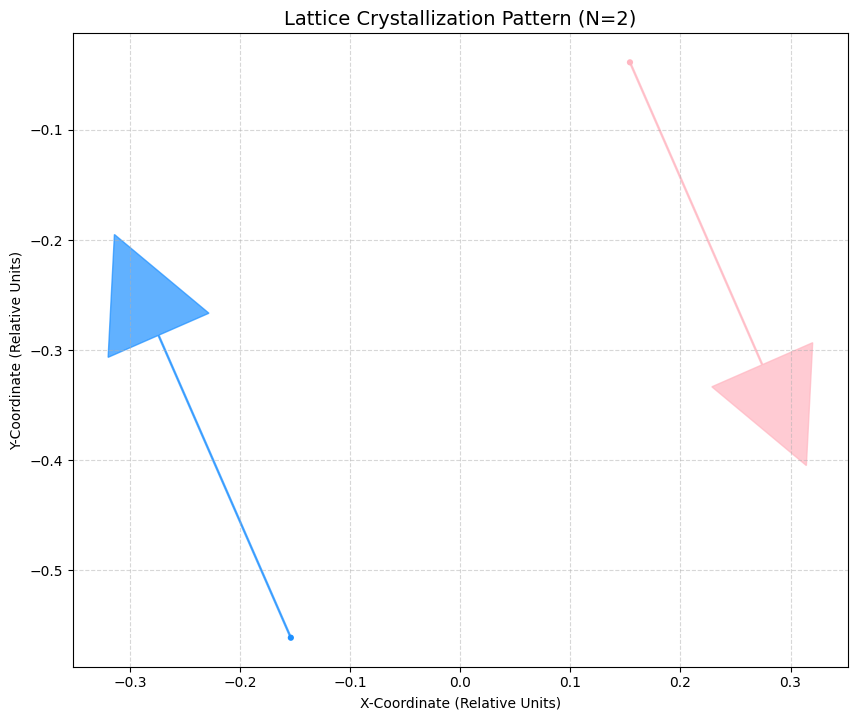

--- Lattice Summary ---
Crystallization Spacing: ~0.7551 units
Blue Phase Population: 50
Pink Phase Population: 55


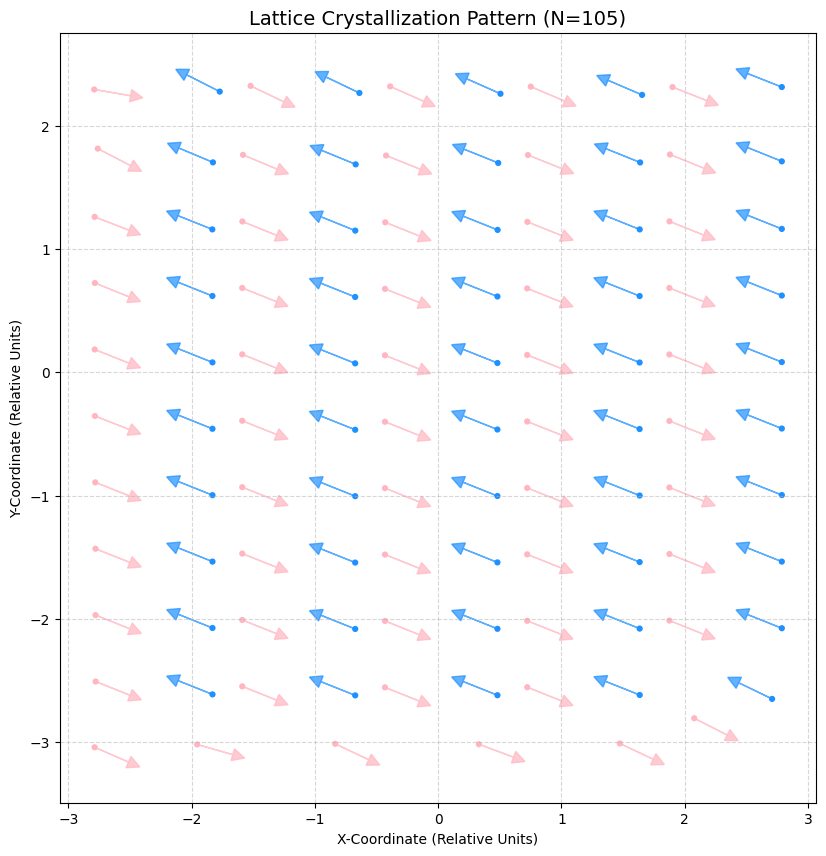

--- Lattice Summary ---
Crystallization Spacing: ~0.7591 units
Blue Phase Population: 78
Pink Phase Population: 72


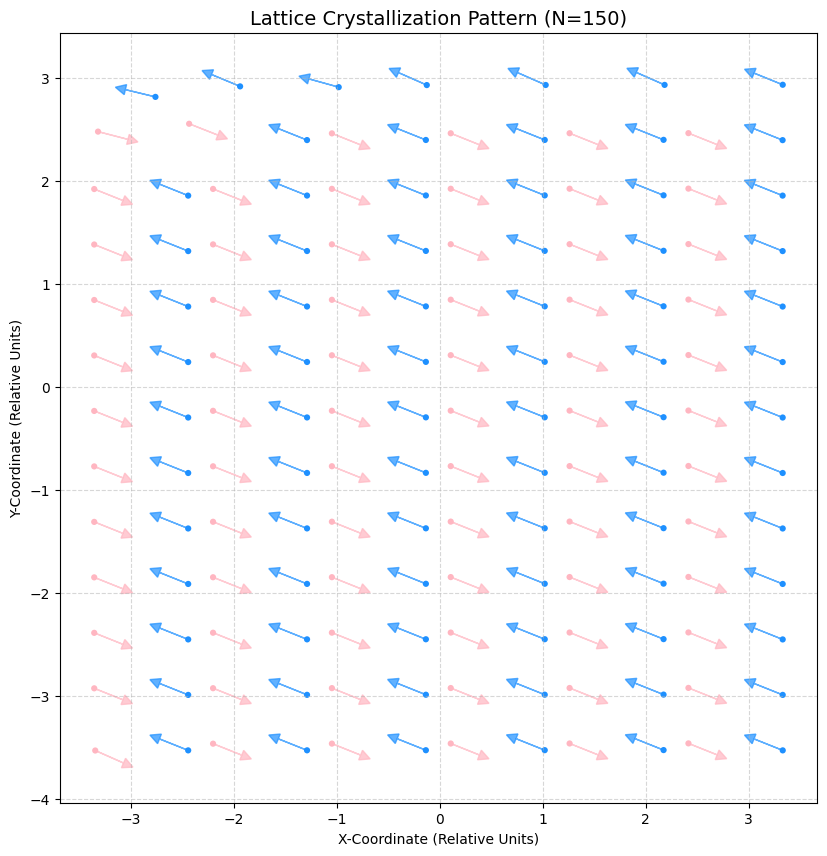

--- Lattice Summary ---
Crystallization Spacing: ~0.7444 units
Blue Phase Population: 31
Pink Phase Population: 31


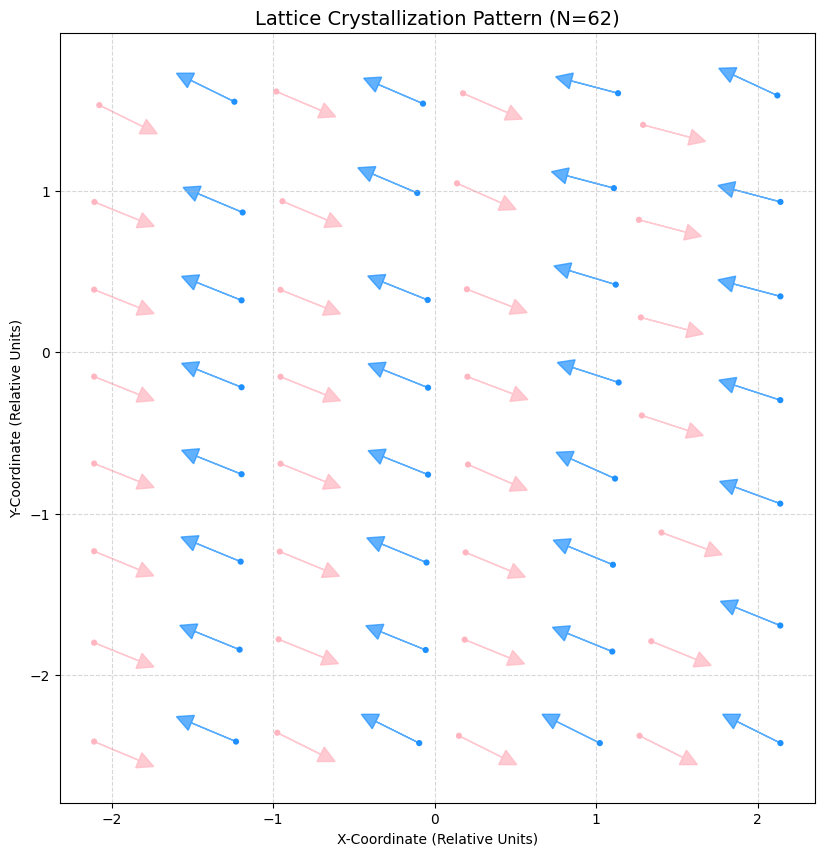

In [10]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from decimal import Decimal
import matplotlib.patches as patches

def analyze_crystallization(file_path, target_n=200):
    # Load data
    try:
        df = pd.read_csv(file_path)
    except:
        return "File not found."

    # Filter for the specific group
    group = df[df["id"].str.startswith(f"{target_n:03d}_")].copy()
    
    # Strip 's' prefix and convert to float for analysis
    group['xf'] = group['x'].str[1:].astype(float)
    group['yf'] = group['y'].str[1:].astype(float)
    group['degf'] = group['deg'].str[1:].astype(float) % 360
    
    # Calculate the centroid and relative positions
    # A summation function for relative x,y patterns
    cx, cy = group['xf'].mean(), group['yf'].mean()
    group['rel_x'] = group['xf'] - cx
    group['rel_y'] = group['yf'] - cy

    # Visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Define polarity based on vertical orientation
    # Upward (0 +/- 90) vs Downward (180 +/- 90)
    for _, row in group.iterrows():
        angle = row['degf']
        
        # Color logic (Blue if pointing up, Pink if pointing down)
        # Using 90 to 270 as the 'downward' hemisphere
        if 90 < angle <= 270:
            tree_color = '#FFB6C1' # Pink
        else:
            tree_color = '#1E90FF' # Blue
            
        # Draw a simplified "crystal unit" (a diamond/triangle)
        # This shows the "spin" of the lattice point
        rad = np.radians(angle + 90) # Adjust for orientation
        dx = 0.3 * np.cos(rad)
        dy = 0.3 * np.sin(rad)
        
        # Plotting the lattice point
        ax.arrow(row['xf'], row['yf'], dx, dy, 
                 head_width=0.1, head_length=0.1, fc=tree_color, ec=tree_color, alpha=0.7)
        ax.scatter(row['xf'], row['yf'], c=tree_color, s=20, edgecolors='none')

    ax.set_aspect('equal')
    ax.set_title(f"Lattice Crystallization Pattern (N={target_n})", fontsize=14)
    ax.set_xlabel("X-Coordinate (Relative Units)")
    ax.set_ylabel("Y-Coordinate (Relative Units)")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Summary of the Summation Pattern
    avg_spacing = np.sqrt((group['xf'].max() - group['xf'].min())**2 + 
                          (group['yf'].max() - group['yf'].min())**2) / np.sqrt(target_n)
    
    print(f"--- Lattice Summary ---")
    print(f"Crystallization Spacing: ~{avg_spacing:.4f} units")
    print(f"Blue Phase Population: {len(group[~((group.degf > 90) & (group.degf <= 270))])}")
    print(f"Pink Phase Population: {len(group[(group.degf > 90) & (group.degf <= 270)])}")
    
    plt.show()




sets = random.sample(range(1, 201), k=10)
print(sets)
for i in sets:
    analyze_crystallization("submission.csv", target_n=i)

TOP 10 LATTICE OFFSETS & ANGLES:
     dx    dy  blue_deg  pink_deg  frequency
0  0.24  0.06      67.9     247.9          2
1 -0.01  0.86     336.4     156.4          2
2  0.24  0.06      66.9     246.9          2
3  0.25  0.04      63.4     243.4          1
4  0.34 -0.06      27.8     213.5          1
5  0.31  0.52      23.6     203.6          1
6  0.30 -0.07      30.7     222.3          1
7  0.30 -0.20      68.0     158.0          1
8  0.29 -0.64     338.2      96.6          1
9  0.28  0.03      55.6     246.2          1


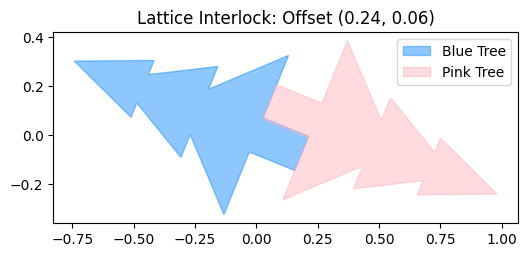

In [11]:
import pandas as pd
import numpy as np

def generate_geometry_report(file_path):
    df = pd.read_csv(file_path)
    # Data Cleaning
    df['xf'] = df['x'].astype(str).str.replace('s', '').astype(float)
    df['yf'] = df['y'].astype(str).str.replace('s', '').astype(float)
    df['degf'] = df['deg'].astype(str).str.replace('s', '').astype(float) % 360
    df['is_blue'] = ~((df.degf > 90) & (df.degf <= 270))
    df['n_val'] = df['id'].apply(lambda x: int(str(x).split('_')[0]))

    # Calculate Score per Group to find the "Masters"
    scores = []
    for n in df['n_val'].unique():
        g = df[df['n_val'] == n]
        side = max(g['xf'].max() - g['xf'].min(), g['yf'].max() - g['yf'].min())
        scores.append({'n': n, 'score': (side**2)/n})
    
    # Analyze the top 10% best groups
    top_ns = pd.DataFrame(scores).sort_values('score').head(20)['n'].values
    master_data = df[df['n_val'].isin(top_ns)]

    # Find the relationship between Blue and their nearest Pink neighbors
    blue = master_data[master_data.is_blue]
    pink = master_data[~master_data.is_blue]
    
    results = []
    for _, b in blue.iterrows():
        # Find closest pink tree in the same group
        group_p = pink[pink['n_val'] == b['n_val']]
        if group_p.empty: continue
        
        dists = np.sqrt((group_p.xf - b.xf)**2 + (group_p.yf - b.yf)**2)
        idx = dists.idxmin()
        p_match = group_p.loc[idx]
        
        results.append({
            'dx': round(p_match.xf - b.xf, 2),
            'dy': round(p_match.yf - b.yf, 2),
            'blue_deg': round(b.degf, 1),
            'pink_deg': round(p_match.degf, 1)
        })

    report = pd.DataFrame(results).value_counts().reset_index(name='frequency')
    return report.head(10)

report = generate_geometry_report("submission.csv")
print("TOP 10 LATTICE OFFSETS & ANGLES:")
print(report)

from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

def plot_tree_pair(dx, dy, b_deg, p_deg):
    TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
    TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
    
    def make_poly(x, y, d):
        p = Polygon(zip(TX, TY))
        return affinity.translate(affinity.rotate(p, d, origin=(0,0)), x, y)

    b_poly = make_poly(0, 0, b_deg)
    p_poly = make_poly(dx, dy, p_deg)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.fill(*b_poly.exterior.xy, color='#1E90FF', alpha=0.5, label='Blue Tree')
    ax.fill(*p_poly.exterior.xy, color='#FFB6C1', alpha=0.5, label='Pink Tree')
    ax.set_aspect('equal')
    plt.title(f"Lattice Interlock: Offset ({dx}, {dy})")
    plt.legend()
    plt.show()

plot_tree_pair(report.iloc[0]['dx'], report.iloc[0]['dy'], report.iloc[0]['blue_deg'], report.iloc[0]['pink_deg'])